Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy 
from scipy import stats
from scipy.stats import shapiro

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

import statsmodels as sm
from statsmodels.stats.power import TTestIndPower

In [2]:
pip install openpyxl

--- Logging error ---
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pip/_vendor/rich/console.py", line 1305, in render
    for render_output in iter_render:
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pip/_vendor/rich/segment.py", line 249, in split_lines
    for segment in segments:
  File "/Library/

Подготовка данных

In [3]:
df = pd.read_excel('AB_Test_Results (2).xlsx')
df.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [4]:
df

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
...,...,...,...
9995,1981,control,0.0
9996,502,variant,0.0
9997,9214,variant,0.0
9998,7741,control,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [6]:
df.shape

(10000, 3)

In [7]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [8]:
df.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [9]:
df.VARIANT_NAME.value_counts()

VARIANT_NAME
variant    5016
control    4984
Name: count, dtype: int64

In [10]:
df.USER_ID.nunique()

6324

In [11]:
df = df.groupby(['USER_ID', 'VARIANT_NAME'], as_index=False).agg({'REVENUE': 'sum'})

In [12]:
df.shape

(7865, 3)

In [13]:
df.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME': 'count'})['VARIANT_NAME'].value_counts()

VARIANT_NAME
1    4783
2    1541
Name: count, dtype: int64

 Определим количество типов встречается у каждого пользователя. Удалим неккоректные строки

In [14]:
unique_ids = \
(df
 .groupby('USER_ID', as_index = False)
 .agg({'VARIANT_NAME': 'count'})
 .query('VARIANT_NAME == 1')
 .USER_ID
 .values
 )

In [15]:
df_new = df[df.USER_ID.isin(unique_ids)].copy(deep = True)

In [16]:
df_new.shape

(4783, 3)

In [17]:
df_new.describe()

,USER_ID,REVENUE
count,4783.000000,4783.000000
mean,4994.395777,0.135873
std,2898.618472,3.011392
min,2.000000,0.000000
25%,2476.000000,0.000000
50%,4975.000000,0.000000
75%,7515.000000,0.000000
max,9998.000000,196.010000


In [18]:
control = df_new.query('VARIANT_NAME == "control"')

test = df_new.query('VARIANT_NAME == "variant"')

**Проверка на нормальность**

In [19]:
alpha = 0.05

st = shapiro(df.REVENUE)
print('Discription is {}normal\n'.format( {True: 'not ',
False: ''}[st[1] < alpha]));

Discription is not normal



График дохода на пользователя по группам 

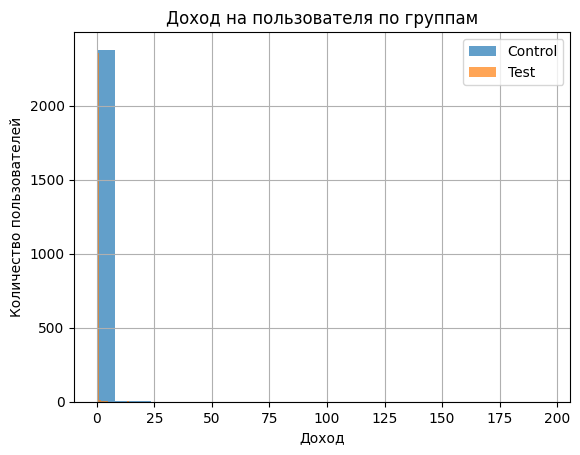

In [20]:
control.REVENUE.hist(bins = 25, alpha = 0.7, label = 'Control')
test.REVENUE.hist(bins = 25, alpha = 0.7, label = 'Test')
plt.title('Доход на пользователя по группам')
plt.xlabel('Доход')
plt.ylabel('Количество пользователей')
plt.legend();

In [21]:
mw_stats = scipy.stats.mannwhitneyu(x=control.REVENUE.values, y = test.REVENUE.values)

mw_stats

MannwhitneyuResult(statistic=2874161.0, pvalue=0.2104875008271777)

Boxplot по пользователям

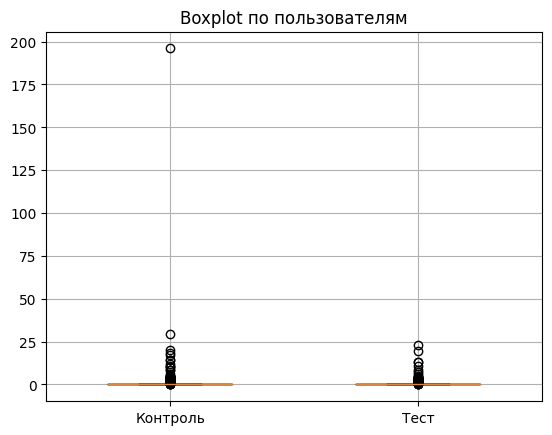

In [22]:
plt.boxplot([control.REVENUE, test.REVENUE],
            labels = ['Контроль', 'Тест'],
            widths = 0.5
            )
plt.title('Boxplot по пользователям', loc='center')
plt.grid(axis='both')

In [23]:
stats.ttest_ind(control.REVENUE.values, test.REVENUE.values, equal_var = False)

Ttest_indResult(statistic=1.3996978409515475, pvalue=0.16172355638776942)

#### Мощность теста

In [24]:
C_mean = control.REVENUE.values.mean()
T_mean = test.REVENUE.values.mean()

C_std = control.REVENUE.values.std()
T_std = test.REVENUE.values.std()

print(len(control.REVENUE.values), len(test.REVENUE.values))

2390 2393


In [25]:
n = len(control.REVENUE.values)
     
S = np.sqrt((T_std**2 +C_std**2)/2)
     
ef = float((C_mean-T_mean)/S)

In [26]:
alpha = 0.05
analysis = TTestIndPower()
analysis = sm.stats.power.TTestIndPower()
result = analysis.solve_power(ef, power=None,
                              nobs1=n, ratio=1.0, alpha=alpha)

result

0.28803096229144043

## Итог:

Статистически значимая разница между группами не значительна, тест мог быть проведен некорректно. При полученных значениях мощности достоверное заключение сделать не представляется возможным. Я бы не рекомендовал применять тестируемое изменение и провести тест повторно, перепроверив корректность его выполнения.